### Where's the Money? Campaign Finance and Election Outcomes in the 2016 U.S. Congressional Races

In this project, I use campaign finance data and election results from the 2016 U.S. Congressional Races. My goal is to train a binary classification model that uses features related to campaign finance, such as contributions, loans, and expenses, to classify a candidate as either a "winner" or a "loser". I ultimately decided to use a Decision Tree Classification Model and a Random Forest Classification Model.

The dataset was retrieved from [here](https://www.kaggle.com/datasets/danerbland/electionfinance). 
A full data dictionary can be found [here](https://www.fec.gov/campaign-finance-data/candidate-summary-file-description/). 

Note: any important variables used in the model will be defined throughout the notebook. The data dictionary is included as a reference, but it is not necessary to flip back and forth. 

#### Part 1: Data Exploration and Cleaning

I use the cells below to obtain summary statistics of the dataset, as well as a sense of how much cleaning I'll need to do prior to training the model. 


In [1]:
# import packages

import os
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
# import data

BASE_PATH = r'/Users/scotty/Documents/Github/33002_23w_p1-sscott11895'

def import_csv(csv_name, skip_row_count=0):
    
    """
    Import a CSV file as a pandas dataframe. 
    
    Inputs:
        csv_name: the name of the csv file, including '.csv'
        skip_row_count: the number of rows at the top of the csv you would like to skip when importing
    
    Returns: a pandas dataframe
    """
    path_creation = os.path.join(BASE_PATH, csv_name)
    new_csv = pd.read_csv(path_creation, skiprows=skip_row_count)
    return new_csv

campaign_data_raw = import_csv('CandidateSummaryAction1.csv')

#### Data Summary
The following lines allow us to view the dataframe. We can see that each row in the dataframe represents information on one candidate. There are 1814 candidates in our dataset, and each candidate is represented by 51 features.

In [3]:
campaign_data_raw.head(20)

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
0,H2GA12121,"ALLEN, RICHARD W",H,GA,12.0,REP,INCUMBENT,2237 PICKENS RD,NaN,AUGUSTA,...,"$60,109.57","$175,613.35","$1,074,949.50","$907,156.21","$1,125,000.00",NaN,1/1/2015,10/19/2016,Y,158708.0
1,H6PA02171,"EVANS, DWIGHT",H,PA,2.0,DEM,CHALLENGER,PO BOX 6578,NaN,PHILADELPHIA,...,NaN,"$105,687.23","$1,406,719.06","$1,298,831.83",NaN,NaN,11/2/2015,10/19/2016,Y,310770.0
2,H6FL04105,"RUTHERFORD, JOHN",H,FL,4.0,REP,OPEN,3817 VICKERS LAKE DRIVE,NaN,JACKSONVILLE,...,NaN,"$35,645.09","$650,855.38","$656,210.29","$60,000.00",NaN,4/1/2016,10/19/2016,Y,286018.0
3,H4MT01041,"ZINKE, RYAN K",H,MT,0.0,REP,INCUMBENT,409 2ND ST W,NaN,WHITEFISH,...,"$83,815.78","$399,122.61","$4,938,943.74","$5,055,942.15",NaN,NaN,1/1/2015,10/19/2016,Y,280476.0
4,H8CA09060,"LEE, BARBARA",H,CA,13.0,DEM,INCUMBENT,"409 13TH ST, 17TH FL",NaN,OAKLAND,...,"$83,690.60","$181,338.23","$1,197,676.61","$949,488.98","$4,401.75",NaN,1/1/2015,10/19/2016,Y,277390.0
5,H6NC04037,"PRICE, DAVID E.",H,NC,4.0,DEM,INCUMBENT,P. O. BOX 1986,NaN,RALEIGH,...,"$216,409.21","$274,287.84","$725,854.52","$430,826.04",NaN,NaN,1/1/2015,10/19/2016,Y,275501.0
6,H2WI02124,"POCAN, MARK",H,WI,2.0,DEM,INCUMBENT,PO BOX 327,NaN,MADISON,...,"$187,549.87","$412,220.80","$970,385.04","$445,438.15",NaN,NaN,1/1/2015,10/19/2016,Y,273520.0
7,H2MA09072,"LYNCH, STEPHEN",H,MA,8.0,DEM,INCUMBENT,105 FARRAGUT RD,NaN,SOUTH BOSTON,...,"$406,586.74","$1,010,654.62","$1,092,218.56","$459,790.68",NaN,"$1,750.00",1/1/2015,10/19/2016,Y,267944.0
8,H6OR02116,"WALDEN, GREGORY P MR.",H,OR,2.0,REP,INCUMBENT,1504 SHERMAN AVENUE,NaN,HOOD RIVER,...,"$997,259.73","$1,264,468.82","$3,004,650.64","$1,911,215.54",NaN,NaN,1/1/2015,10/19/2016,Y,267179.0
9,H2MA04073,"KENNEDY, JOSEPH P III",H,MA,4.0,DEM,INCUMBENT,PO BOX 590464,NaN,NEWTON,...,"$1,400,008.58","$2,858,165.71","$2,784,362.26","$1,537,844.39",NaN,NaN,1/1/2015,10/19/2016,Y,261356.0


In [4]:
campaign_data_raw.shape

(1814, 51)

#### Feature Review
Looking at the column names and the datatypes of each column, it's clear that there are a lot of columns that will not be helpful. For example, we have contribution, loan, and loan repayment data, split into different categories. While I'm interested in contribution data (which can indicate how popular a candidate is) and loan data (how much cash the candidate needs to borrow up front), I'm less interested in repayment data. 

Additionally, it looks like most columns have been read in as strings, even though it's financial data. Upon closer inspection, financial numbers contain the characters '$' and ',' , which are causing these fields to be read as strings, so some cleaning will need to take place before we can use this information. 

In [5]:
campaign_data_raw.dtypes

can_id                    object
can_nam                   object
can_off                   object
can_off_sta               object
can_off_dis              float64
can_par_aff               object
can_inc_cha_ope_sea       object
can_str1                  object
can_str2                  object
can_cit                   object
can_sta                   object
can_zip                  float64
ind_ite_con               object
ind_uni_con               object
ind_con                   object
par_com_con               object
oth_com_con               object
can_con                   object
tot_con                   object
tra_fro_oth_aut_com       object
can_loa                   object
oth_loa                   object
tot_loa                   object
off_to_ope_exp            object
off_to_fun                object
off_to_leg_acc            object
oth_rec                   object
tot_rec                   object
ope_exp                   object
exe_leg_acc_dis           object
fun_dis   

In [6]:
campaign_data_raw.columns

Index(['can_id', 'can_nam', 'can_off', 'can_off_sta', 'can_off_dis',
       'can_par_aff', 'can_inc_cha_ope_sea', 'can_str1', 'can_str2', 'can_cit',
       'can_sta', 'can_zip', 'ind_ite_con', 'ind_uni_con', 'ind_con',
       'par_com_con', 'oth_com_con', 'can_con', 'tot_con',
       'tra_fro_oth_aut_com', 'can_loa', 'oth_loa', 'tot_loa',
       'off_to_ope_exp', 'off_to_fun', 'off_to_leg_acc', 'oth_rec', 'tot_rec',
       'ope_exp', 'exe_leg_acc_dis', 'fun_dis', 'tra_to_oth_aut_com',
       'can_loa_rep', 'oth_loa_rep', 'tot_loa_rep', 'ind_ref', 'par_com_ref',
       'oth_com_ref', 'tot_con_ref', 'oth_dis', 'tot_dis',
       'cas_on_han_beg_of_per', 'cas_on_han_clo_of_per', 'net_con',
       'net_ope_exp', 'deb_owe_by_com', 'deb_owe_to_com', 'cov_sta_dat',
       'cov_end_dat', 'winner', 'votes'],
      dtype='object')

When reviewing the summary statistics, a few columns stand out. 

#### Winner
One is that there are 471 winners in our dataset out of 1814 candidates, which means that there arae 1343 losers. Unbalanced categories are expected in election data, as the number of candidates is generally larger than the number of open positions. The data dictionary notes that winners are indicated with a "Y", and losers are indicated with a NaN. I am going to manipulate this to be an indicator variable, where winners are tagged with a 1, losers are tagged with a 0. 

#### can_off
There are a number of categories that provide information about individual candidates, such as candidate ID, candidate name, candidate office, candidate office district, candidate party affiliation, whether the candidate was an incumbent, a challenger, or neither (i.e. the race was open) in their race, and candidate str1 and candidate str2, which relate to a candidate's office address, etc. In reviewing candidate office, we see that this is represented by three unique values: "P" for presidential election, "H" for House of Representatives election, and "S" for senate election. Because there is only one winner for the president, I'm going to drop candidates that ran for president, because it will be hard to train the model on such a small positive sample.

#### Frequency of NaN Values
It appears there are a number of NaN values in my dataset. Below, I review how many NaN values are in each column, and begin cleaning columns that I anticipate using in my final model. Once I am done cleaning these columns, I will drop the extraneous columns. 

In [7]:
campaign_data_raw.describe(include='all')

# citation: https://www.w3resource.com/pandas/dataframe/dataframe-describe.php#:~:text=describe(include%3D%5B'O'%5D,will%20include%20all%20numeric%20columns.

,can_id,can_nam,can_off,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
count,1814,1814,1814,1814,1812.000000,1813,1812,1789,122,1813,...,700,1434,1643,1665,732,23,1814,1814,471,379.000000
unique,1814,1803,3,57,NaN,24,3,1768,119,1062,...,673,1407,1613,1653,611,22,232,175,1,NaN
top,H2GA12121,"CLEMENTS, THOMAS PATRICK",H,CA,NaN,REP,CHALLENGER,416 CHEROKEE LANE,#106,LAS VEGAS,...,$100.00,$5.00,$600.00,"$77,314.34","$250,000.00","$5,000.00",1/1/2015,10/19/2016,Y,NaN
freq,1,2,1429,183,NaN,882,850,2,2,22,...,7,5,5,2,12,2,729,898,471,NaN
mean,NaN,NaN,NaN,NaN,7.903422,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184928.211082
std,NaN,NaN,NaN,NaN,10.264533,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40186.524817
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68481.000000
25%,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158973.500000
50%,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187909.000000
75%,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210094.500000


In [8]:
campaign_data_raw['winner'] = np.where(campaign_data_raw['winner'] == 'Y', 1, 0)

In [9]:
# there were 1429 candidates in the House race, with 435 winners
# there were 158 candidates in the Presidential race, with 1 winner
# there were 227 candidates in the Senate race, with 35 winners

campaign_data_raw.groupby('can_off').count()

,can_id,can_nam,can_off_sta,can_off_dis,can_par_aff,can_inc_cha_ope_sea,can_str1,can_str2,can_cit,can_sta,...,cas_on_han_beg_of_per,cas_on_han_clo_of_per,net_con,net_ope_exp,deb_owe_by_com,deb_owe_to_com,cov_sta_dat,cov_end_dat,winner,votes
can_off,,,,,,,,,,,,,,,,,,,,,
H,1429,1429,1429,1427,1428,1427,1416,108,1429,1425,...,593,1180,1374,1386,603,18,1429,1429,1429,379
P,158,158,158,158,158,158,153,11,158,158,...,40,84,63,68,44,3,158,158,158,0
S,227,227,227,227,227,227,220,3,226,223,...,67,170,206,211,85,2,227,227,227,0


In [10]:
campaign_data_raw = campaign_data_raw[campaign_data_raw['can_off'] != 'P']

In [11]:
campaign_data_raw.isna().sum().sort_values(ascending=False)

off_to_leg_acc           1656
exe_leg_acc_dis          1656
off_to_fun               1656
fun_dis                  1654
deb_owe_to_com           1636
par_com_ref              1633
oth_loa_rep              1630
oth_loa                  1597
can_str2                 1545
tra_to_oth_aut_com       1511
tra_fro_oth_aut_com      1405
can_loa_rep              1369
tot_loa_rep              1359
oth_com_ref              1305
par_com_con              1278
votes                    1277
oth_rec                  1139
can_loa                  1053
can_con                  1040
tot_loa                  1030
cas_on_han_beg_of_per     996
deb_owe_by_com            968
off_to_ope_exp            926
oth_dis                   883
ind_ref                   856
tot_con_ref               812
oth_com_con               669
cas_on_han_clo_of_per     306
ind_uni_con               177
ind_ite_con               147
ind_con                   111
net_con                    76
tot_con                    61
net_ope_ex

In [12]:
# drop candidate specific columns
can_cols_to_drop = ['can_cit','can_off_sta', 'can_sta', 'can_off_dis',
                    'can_str1', 'can_str2', 'can_zip']


campaign_data_clean = campaign_data_raw.drop(can_cols_to_drop, axis=1)

#### Party Affiliation and Challenger/Incumbent/Open Status

The majority of candidates are either Democrats or Republicans. I'm going to code all other candidates' parties as  "OTHER".


There are two candidates where it does not say if they are a challenger, an incumbent, or if the race was open. I looked up Vaitinasa Salu Hunkin-Finau on [Ballotpedia](https://ballotpedia.org/United_States_House_of_Representatives_election_in_American_Samoa,_2016), which says that she was a challenger. I looked up Steve Lindbeck on [Ballotpedia](https://ballotpedia.org/United_States_House_of_Representatives_election_in_Alaska,_2016), which says that he was also a challenger. I manually insert this information. 

In [13]:
# review counts of candidate party affiliations

campaign_data_clean.groupby('can_par_aff')['can_id'].count()

can_par_aff
CON      3
DEM    691
DFL      4
GRE     12
ID       1
IDP      1
IND     48
LIB     26
NNE      5
NON      2
NPA      8
NPP      1
OTH     11
PPT      1
REP    830
UN       3
UNK      6
W        2
Name: can_id, dtype: int64

In [14]:
# change non-DEM and non-REP candidate party affiliations to 'OTHER'

campaign_data_clean['can_par_aff'] = np.where(
    ((campaign_data_clean['can_par_aff'] != 'DEM') & (campaign_data_clean['can_par_aff'] != 'REP')),
    'OTHER',
    campaign_data_clean['can_par_aff'])


# editing Vaitinasa Salu Hunkin-Finau and Steve Lindbeck's statuses' to CHALLENGER

campaign_data_clean[campaign_data_clean['can_inc_cha_ope_sea'].isna()]
campaign_data_clean.at[1812,'can_inc_cha_ope_sea'] = 'CHALLENGER'
campaign_data_clean.at[1813,'can_inc_cha_ope_sea'] = 'CHALLENGER'

#### Length of Campaign
The dataset contains the start and end dates of campaign. I want to create a new feature, called campaign_days_total, that calculates the total length of the campaign. Note that generally the earliest date a candidate starts campaigning is January 1 of the year prior to the election year. In this case, that date is January 1, 2015. The last day of the campaign is typically December 31 of the election year. In this case, that date is December 31, 2016. Below, I edit the data so that if a candidate lists their start date of their campaign prior to January 1, 2015, I edit their start date to 1/1/2015. If a candidate lists their end date after December 31, 2016, I edit their end date to December 31, 2016. 



In [15]:
# format cov_sta_dat and cov_end_date to datetime format
# update start date to 1/1/2015 if current date listed is before 1/1/2015
# update end date to 12/31/2016 if current date listed is after 12/31/2016

campaign_data_clean['cov_sta_dat'] = pd.to_datetime(campaign_data_clean['cov_sta_dat'])
campaign_data_clean['cov_sta_dat'].mask(campaign_data_clean['cov_sta_dat'] < '2015-01-01', dt.datetime(2015, 1, 1), inplace=True)

campaign_data_clean['cov_end_dat'] = pd.to_datetime(campaign_data_clean['cov_end_dat'])
campaign_data_clean['cov_end_dat'].mask(campaign_data_clean['cov_end_dat'] > '2016-12-31', dt.datetime(2016, 12, 31), inplace=True)

# calculate total campaign days

campaign_data_clean['campaign_days_total'] = (campaign_data_clean['cov_end_dat']-campaign_data_clean['cov_sta_dat']).dt.days

# check that campaign_days_total max and min values make sense

campaign_data_clean['campaign_days_total'].max(), campaign_data_clean['campaign_days_total'].min()

# drop cov_sta_dat and cov_end_dat
campaign_data_clean = campaign_data_clean.drop(['cov_sta_dat','cov_end_dat'], axis=1)


#### Campaign Contributions

Any field that ends with "_con" refers to campaign contributions. Based on our review of NaN values, we see that there are a lot of NaN values for the columns can_con, ind_con, par_com_con, oth_com_con, and tot_con. 

**Candidate contribution**: the contributions that the candidate makes to his own campaign

**Individual contribution**: the contributions that individuals make to his campaign as opposed to Political Action Committees (PACs)

**Party Committee Contribution**: the contributions from party committees

**Other Committee Contribution**: contributions from Political Action Committees (PACs)

**Total Contributions**: the total sum of candidate, individual, party committee contributions, and other committee contributions

Based on the [Federal Election Commision's website](https://www.fec.gov/help-candidates-and-committees/candidate-taking-receipts/using-personal-funds-candidate/#:~:text=of%20the%20cand), candidates are required to report any money that comes in in these categories. We can assume that if the cells are empty, then the candidate did not generate any money for those categories, and we will fill these cells with $0.

We also saw that most financial contribution information includes characters ('$', ',') that cause the figures to be read in as strings. In the code block below, we clean clean the data so that we can convert these columns to numerical values. 

I then validate that the total contribution ("tot_con") column is actually the total of the other contribution columns by creating my own column "total_contribution_test", which sums all the contribution columns, and con_diff which take my "total_contribution_test" column and subtracts "tot_con". The resulting con_diff column shows that there are some major discrepancies between the tot_con column and the actual total contributions. To address this, if con_diff is greater than or equal to 0, we are going to use the value from total_contribution_test because it adequately factors in all contributions. If con_diff is less than 0, this means that the tot_con value is larger than my manual sum. We can imagine that a campaign (especially smaller campaigns) may just compute the total contributions without paying too much attention to the various categories that make up the total. As such, in this case, we are going to keep the tot_con value, as that is probably more accurate based on this scenario. 

Lastly, I drop 'con_diff' and 'total_contribution_test' columns. 

In [16]:
# remove the characters "$),(" from the dataset, then convert columns from strings to numerical categories

campaign_data_clean = campaign_data_clean.apply(lambda x: x.str.replace(r'\$','', regex=True) if x.dtype == "object" else x)
campaign_data_clean = campaign_data_clean.apply(lambda x: x.str.replace(r'\,','', regex=True) if x.dtype == "object" else x)
campaign_data_clean = campaign_data_clean.apply(lambda x: x.str.replace(r'\(','-', regex=True) if x.dtype == "object" else x)
campaign_data_clean = campaign_data_clean.apply(lambda x: x.str.replace(r'\)','', regex=True) if x.dtype == "object" else x)

# create a list of columns related to contributions

contribution_cols = ['ind_con', 'par_com_con', 'oth_com_con', 'can_con', 'tot_con']

# fill NaN values in columns related to contributions with 0s
campaign_data_clean[contribution_cols] = campaign_data_clean[contribution_cols].apply(pd.to_numeric).fillna(0)

# validate tot_con column

campaign_data_clean['total_contribution_test'] = (
    campaign_data_clean['ind_con'] +               
    campaign_data_clean['par_com_con'] +            
    campaign_data_clean['oth_com_con'] +          
    campaign_data_clean['can_con']
)

campaign_data_clean['con_diff'] = campaign_data_clean['total_contribution_test'] - campaign_data_clean['tot_con'] 

campaign_data_clean['con_diff'].max(), campaign_data_clean['con_diff'].min()

# update tot_con column where if the con_diff is >= 0, use the manual total_contribution_test value we created.
# otherwise, keep the value in tot_con. 

campaign_data_clean['tot_con'] = np.where(campaign_data_clean['con_diff'] >= 0, campaign_data_clean['total_contribution_test'], campaign_data_clean['tot_con'])


# drop total_contribution_test and con_diff columns

campaign_data_clean = campaign_data_clean.drop(['con_diff', 'total_contribution_test'], axis=1)


#### Loan Data

I also consider loan data for the model. 

Any field that ends with "_loa" refers to campaign loans. Based on our review of NaN values, we see that there are a lot of NaN values for the columns can_loa, oth_loa, and tot_loa.

**Candidate loan**: loans that the candidate makes to his or her own campaign

**Other loan**: the loans, often from banks, and must be made in the normal course of business including interest rates and collateral 

**Total loan**: the total sum of candidate and other loan columns

Similar to contributions, candidates are required to report this information. As such, all NaN values can be interpreted as that this information was not available. As such, I'll fill this information in with 0s. 


Also similar to contributions, I validate the total loan ("tot_loa") column to confirm that it actually is the total of the other loan columns. I create my own column "total_loan_test", which sums all the loan columns, and loa_diff, which takes my "total_loan_test" column and subtracts "tot_loa". 

The resulting loa_diff column shows that there are some major discrepancies between the tot_loa column and the actual loan total. 

To address this, if loa_diff is greater than or equal to 0, we are going to use the value from total_loan_test because it accurately factors in all loan information. If con_diff is less than 0, this means that the tot_loa value is larger than my manual sum. We can imagine that a campaign (especially smaller campaigns) may just compute the total loans without paying too much attention to the various categories that make up the total. As such, in this case, we are going to keep the tot_loa value, as that is probably more accurate based on this scenario. 

Lastly, I drop 'loa_diff' and 'total_loa_test' columns.

In [17]:
# validating total loan column

loan_cols = ['can_loa', 'oth_loa', 'tot_loa']
campaign_data_clean[loan_cols] = campaign_data_clean[loan_cols].apply(pd.to_numeric).fillna(0)
campaign_data_clean['total_loan_test'] = campaign_data_clean['can_loa'] + campaign_data_clean['oth_loa']
campaign_data_clean['loa_diff'] = campaign_data_clean['total_loan_test'] - campaign_data_clean['tot_loa']
campaign_data_clean['loa_diff'].max(), campaign_data_clean['loa_diff'].min()

campaign_data_clean['tot_loa'] = np.where(campaign_data_clean['loa_diff'] >= 0, campaign_data_clean['total_loan_test'], campaign_data_clean['tot_loa'])

# drop 'total_loan_test' and 'loa_diff' cols

campaign_data_clean = campaign_data_clean.drop(['total_loan_test', 'loa_diff'], axis=1)


#### Total Receipts, Operating Expenditures, and Cash On Hand

The last columns that I want to use to inform the model are total receipts (tot_rec, which is anything of value [received by a political committee](https://ballotpedia.org/Receipts_v._contributions), operating expenditures (ope_exp), and cash on hand at the end of the period (cas_on_hand_clo_of_per). 

All of these variables have a lot of NaN values. To address, I first plot total contributions vs. operating expenses, and total contributions vs. total receipts. This is to determine if using total contributions to fill in these numbers would be reasonable. The slope of both of these plots is approximately 1, which means that filling NaN values with the total contribution value is reasonable. 

To fill NaN values related to cash on hand, I'm going to use (Total Contributions + Total Receipts) - (operating expenditures), which is the definition of cash on hand. 

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


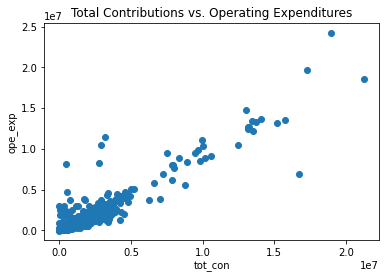

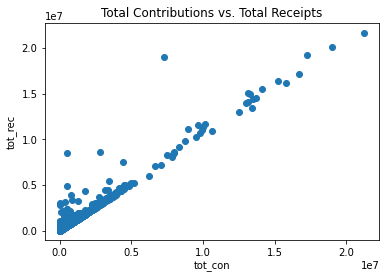

In [18]:
# convert tot_rec, ope_exp, and cas_on_han_clo_of_per from categorical to numerical variables
finance_vars = ['tot_rec', 'ope_exp', 'cas_on_han_clo_of_per']

campaign_data_clean[finance_vars] = campaign_data_clean[finance_vars].apply(pd.to_numeric)

# plot total contributions vs. operating expenses; confirm linear relationship; slope = 0.91 which is approximately 1

print(linregress(campaign_data_clean['tot_con'], campaign_data_clean['ope_exp']))

fig, ax = plt.subplots()
ax.scatter(campaign_data_clean['tot_con'], campaign_data_clean['ope_exp'])
plt.xlabel('tot_con') 
plt.ylabel('ope_exp') 
plt.title("Total Contributions vs. Operating Expenditures")

campaign_data_clean['ope_exp'] = campaign_data_clean['ope_exp'].fillna(campaign_data_clean['tot_con'])

# citation: https://stackoverflow.com/questions/9538525/calculating-slopes-in-numpy-or-scipy


# plot total contributions vs. total receipts; confirm linear relationship; slope is 1.079 which is approximately 1

fig, ax = plt.subplots()
ax.scatter(campaign_data_clean['tot_con'], campaign_data_clean['tot_rec'])
plt.xlabel('tot_con') 
plt.ylabel('tot_rec') 
plt.title("Total Contributions vs. Total Receipts")

print(linregress(campaign_data_clean['tot_con'], campaign_data_clean['tot_rec']))

campaign_data_clean['tot_rec'] = campaign_data_clean['tot_rec'].fillna(campaign_data_clean['tot_con'])

# fill "cas_on_han_clo_of_per" based on total contribution, total receipts, and operating expenditures data

campaign_data_clean['cas_on_han_clo_of_per'] = np.where(
     campaign_data_clean['cas_on_han_clo_of_per'].isnull(),campaign_data_clean['tot_con']+campaign_data_clean['tot_rec']-campaign_data_clean['ope_exp'],
     campaign_data_clean['cas_on_han_clo_of_per']
)
           

#### Creating New Ratios

In addition to the features provided in the data, I also created a few additional ratios. 

**Individual contribution as percent of total contributions**: indicates how well the candidate did at the grassroots level (ind_con_tot_con_ratio)

**Other Committee contribution as percent of total contributions**: indicates how heavily the candidate relied on PACs
(oth_con_tot_con_ratio)

**Candidate contribution as percent of total contributions**: indicates wealth of candidate/how able they were to fund their own campaign (can_con_tot_con_ratio)

**Total loans as percent of total operating expenditures**: indicates how well the candidate was able to raise money for the campaign when needed or if they needed to rely heavily on loans (tot_loa_ope_exp_ratio)



In [19]:
# Individual contribution as percent of total contributions

campaign_data_clean['ind_con_tot_con_ratio'] = campaign_data_clean['ind_con']/campaign_data_clean['tot_con']
campaign_data_clean['ind_con_tot_con_ratio'] = campaign_data_clean['ind_con_tot_con_ratio'].fillna(0)

# Other Committee contribution as percent of total contributions

campaign_data_clean['oth_con_tot_con_ratio'] = campaign_data_clean['oth_com_con']/campaign_data_clean['tot_con']
campaign_data_clean['oth_con_tot_con_ratio'] = campaign_data_clean['oth_con_tot_con_ratio'].fillna(0)

#Candidate contribution as percent of total contributions

campaign_data_clean['can_con_tot_con_ratio'] = campaign_data_clean['can_con']/campaign_data_clean['tot_con']
campaign_data_clean['can_con_tot_con_ratio'] = campaign_data_clean['oth_con_tot_con_ratio'].fillna(0)

# Total loans as percent of total operating expenditures

campaign_data_clean['tot_loa_ope_exp_ratio'] = campaign_data_clean['tot_loa']/campaign_data_clean['ope_exp']
campaign_data_clean['tot_loa_ope_exp_ratio'] = campaign_data_clean['tot_loa_ope_exp_ratio'].fillna(0)

campaign_data_clean['tot_loa_ope_exp_ratio'] = np.where(campaign_data_clean['tot_loa_ope_exp_ratio'] == np.inf, 0, campaign_data_clean['tot_loa_ope_exp_ratio'])


#### Drop Extraneous Columns

In the last step of cleaning the data, we will drop columns that we do not want to use to train the model. Below is an explanation of why we are dropping various variables. In the code block below, I list the variables that we want to drop.

**Unique Candidate Information**: We will drop can_id and can_name, because these are unique to each row and will not help us find a binary classification model. 

**Votes**: The dataset only includes vote counts for winners. This is not useful because we have no data for losers. 

**Presidential Candidate Variables**: The variables off_to_fun, off_to_leg_acc, exe_leg_acc_dis, fun_dis only apply to presidential candidates. Because we aren't considering these candidates, I am dropping these columns. 

**Refunds**: The variables ind_ref, par_com_ref, oth_com_ref, tot_conf_ref all refer to refunds on campaign contributions, which come up on a case by case basis and are not related to how likely a candidate is to win.

**Debt**: The variables deb_owe_to_com, deb_owe_by_com are related to debt. 

**Transfers**: The variables tra_to_oth_auth_com, tra_fro_oth_auth_com are related to transfers to or from other authorized committees. 

**Disbursements**: We are not using oth_dis, tot_dis, which refer to disbursements. 

**Loan Repayments**: The variables oth_loa_rep, can_loa_rep,tot_loa_rep are related to loan repayments. 

**Extraneous Contributions**: The variables ind_uni_con, ind_ite_con, net_con are additional contribution metrics that are encapsulated by existing loan metrics (i.e. ind_uni_con + ind_ite_con = individual contributions). 

**Extraneous Receipts**: The variable oth_rec is miscellaneous receipts, such as bank interest. 

**Extraneous Expenditures**: The variables off_to_ope_exp and net_ope_exp are encapsulated in total expenditure column. 

**Extraneous Cash**: Instead of using the variable cas_on_han_beg_of_per, we decided to just use cash on hand at the close of the period. 


In [20]:
cols_to_drop = ['can_nam', 'can_id','votes','off_to_fun','off_to_leg_acc','exe_leg_acc_dis',
                'fun_dis','ind_ref', 'par_com_ref', 'oth_com_ref',
                'deb_owe_to_com','deb_owe_by_com','oth_loa_rep',
                'can_loa_rep','tra_to_oth_aut_com', 'tra_fro_oth_aut_com',
                'oth_rec','oth_dis', 'off_to_ope_exp', 'tot_loa_rep',
                'ind_uni_con', 'ind_ite_con', 'cas_on_han_beg_of_per',
                'tot_con_ref', 'tot_dis', 'net_con','net_ope_exp'
                ]

campaign_data_clean = campaign_data_clean.drop(cols_to_drop, axis=1)

print(campaign_data_clean.isna().sum().sort_values(ascending=False))
campaign_data_clean.dtypes
# no NaN values
# 3 categorical variables
# 17 remaining categories are numeric

can_off                  0
can_par_aff              0
can_con_tot_con_ratio    0
oth_con_tot_con_ratio    0
ind_con_tot_con_ratio    0
campaign_days_total      0
winner                   0
cas_on_han_clo_of_per    0
ope_exp                  0
tot_rec                  0
tot_loa                  0
oth_loa                  0
can_loa                  0
tot_con                  0
can_con                  0
oth_com_con              0
par_com_con              0
ind_con                  0
can_inc_cha_ope_sea      0
tot_loa_ope_exp_ratio    0
dtype: int64


can_off                   object
can_par_aff               object
can_inc_cha_ope_sea       object
ind_con                  float64
par_com_con              float64
oth_com_con              float64
can_con                  float64
tot_con                  float64
can_loa                  float64
oth_loa                  float64
tot_loa                  float64
tot_rec                  float64
ope_exp                  float64
cas_on_han_clo_of_per    float64
winner                     int64
campaign_days_total        int64
ind_con_tot_con_ratio    float64
oth_con_tot_con_ratio    float64
can_con_tot_con_ratio    float64
tot_loa_ope_exp_ratio    float64
dtype: object

#### Model


For my model, I decided to look at the accuracy of two models: 
 - Decision Tree Classifier
 - Random Forest Classifer

**Decision Tree Classifer**
The first model I tested was the Decision Tree Classifier. I used One-hot Encoder on my categorical variables (candidate status as a challenger, incumbent, or ran in an open race), candidate office features (i.e. House or Senate rate), and candidate party affiliation (Democrat, Republican, or Other). I then created training and testing data, training and testing labels, and then determined the weights given to the positive class (winner = 1) and negative class (loser = 0). In the final dataframe, I had 1186 losers, and 470 winners. This means that we need to weight winners by 2.5 in the dataframe and losers by 1, to account for the unbalanced sample. 

In terms of parameters, I experimented with different min_samples_split. 30 ultimately gave me the best accuracy score. I also experimented with differet min-samples_leaf, and ultimately 5 gave me the best accuracy score. I set class_weight to a dictionary that weighted the winners observations at 2.5 and the losers observations at 1. 

The mean accuracy on the test data and labels was 0.9427, or 94.3% accurate. The top features that the model focused on in order to make predictions were other committee contributions (83%), which would include the amount of money received from PACs and Super PACs, as well as if the the candidate was an incumbent or not (10%). Notable mentions were also total receipts (3%) and cash on hand at the close of the period (1%). 

In looking at the 19 occurrences where the model made incorrect predictions on the test data, we see that the model mostly guessed that these people had won when they really lost their election. Most of these observations had really large values for other committee contributions, which makes me think the model may be overemphasizing the importance of super pac contributions. 

In [21]:
def merge_one_hot_encode_variable_into_df(df, cat_col, new_col_names): 
    """
    Takes in pandas series from a dataframe that consists of a categorical variable,
    one hot encodes this series, combines the output array with 
    the original dataframe, and then drops the original column with the categorical variable.
    
    Inputs:
        df: datatframe that contains the categorical variable
        cat_col: a string; this is the name of the categorical variable column
        new_col_names: a list of names that the new columns will be named after we concatenate the 
        one hot encoded array to the original dataframe
    
    Returns: a pandas dataframe
    """
    data = df[cat_col]
    values = np.array(data)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)

    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    hot_encoded = onehot_encoder.fit_transform(integer_encoded)

    # attach onehot encoded array to df
    new_df = pd.DataFrame(hot_encoded, columns=[new_col_names])
    new_df
    df = df.reset_index().drop('index', axis=1)

    #concat with original data
    final_df = pd.concat([df, new_df], axis=1).drop([cat_col], axis=1)
    
    return final_df

# one hot encoder for challenger, incumbent, open seat feature

campaign_data_clean = merge_one_hot_encode_variable_into_df(campaign_data_clean, 
                                                            cat_col = 'can_inc_cha_ope_sea',
                                                            new_col_names = ['Challenger', 'Incumbent', 'Open'])

# one hot encoder for candidate office feature

campaign_data_clean = merge_one_hot_encode_variable_into_df(campaign_data_clean, 
                                                            cat_col = 'can_off',
                                                            new_col_names = ['House', 'Senate'])

# one hot encoder for candidate party affiliation

campaign_data_clean = merge_one_hot_encode_variable_into_df(campaign_data_clean, 
                                                            cat_col = 'can_par_aff',
                                                            new_col_names = ['DEM', 'OTHER', 'REP'])


In [22]:
# create training and testing dating, where test data size is 20% of the total data

X = campaign_data_clean
y = campaign_data_clean['winner']
X.shape, y.shape

train, test = train_test_split(campaign_data_clean, test_size=0.2, random_state = 35)


In [23]:
# check that the total number of winners and losers in the training and testing data

print(train[train['winner'] == 1].shape) # 376 observations
print(train[train['winner'] == 0].shape) # 948 observations

print(test[test['winner'] == 1].shape) # = 94
print(test[test['winner'] == 0].shape) # 238

(376, 25)
(948, 25)
(94, 25)
(238, 25)


In [24]:
# create variables for the labels in the training and testing data

train_label = train['winner']
test_label = test['winner']

# remove the winner columns from the training and testing data
train = train.drop(['winner'], axis=1)
test = test.drop(['winner'], axis=1)


In [25]:
# determine weights of positive class vs. negative class
# the groupby call below shows that we have 470 winners and 1186 losers in the dataframe. 
# as such, we weight winners by 2.5 and losers by 1.

campaign_data_clean.groupby('winner').count()


,ind_con,par_com_con,oth_com_con,can_con,tot_con,can_loa,oth_loa,tot_loa,tot_rec,ope_exp,...,can_con_tot_con_ratio,tot_loa_ope_exp_ratio,"(Challenger,)","(Incumbent,)","(Open,)","(House,)","(Senate,)","(DEM,)","(OTHER,)","(REP,)"
winner,,,,,,,,,,,,,,,,,,,,,
0,1186,1186,1186,1186,1186,1186,1186,1186,1186,1186,...,1186,1186,1186,1186,1186,1186,1186,1186,1186,1186
1,470,470,470,470,470,470,470,470,470,470,...,470,470,470,470,470,470,470,470,470,470


In [26]:
# class weights dictionary:
class_dict = {1:2.5, 0:1}

# create the model

DT_clf = sklearn.tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split=30,
                                             min_samples_leaf=5,
                                             random_state=35, 
                                             class_weight = class_dict
                                            )

DT_clf.fit(train, train_label)

# classification accuracy 
DT_clf.score(test, test_label)

0.9427710843373494

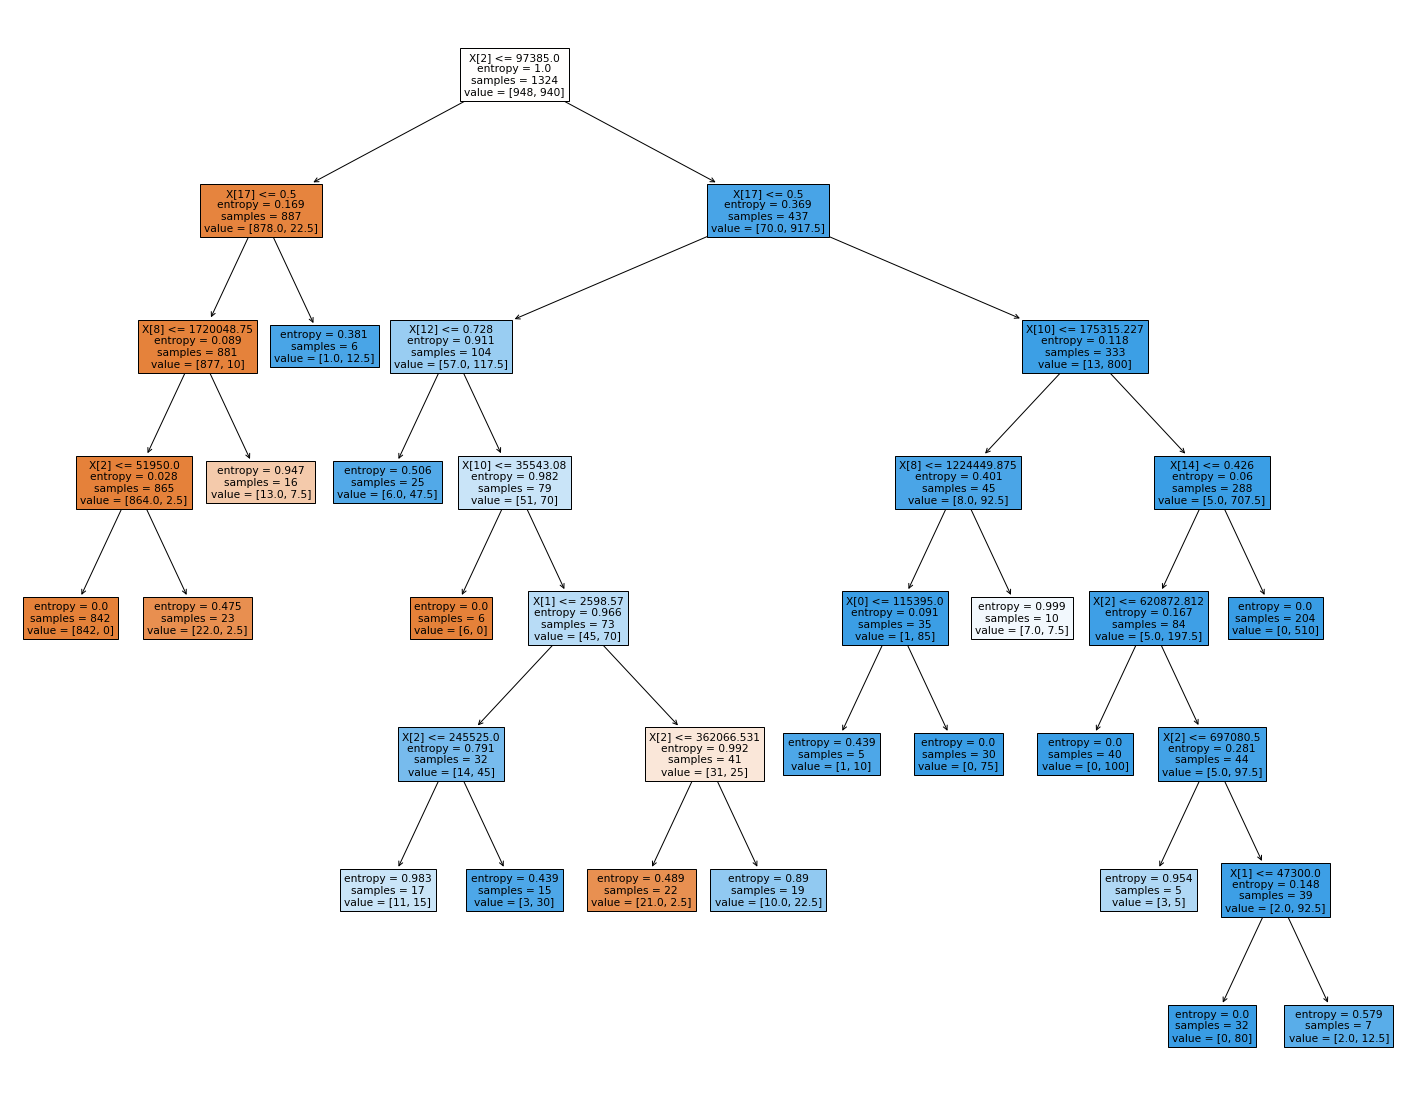

In [27]:
# Plot the fitted DecisionTreeClassifier

fig = plt.figure(figsize=(25,20))
tree_plot = tree.plot_tree(DT_clf,
                   filled=True)

In [28]:
# review top features

vals = np.array(DT_clf.feature_importances_)
features = np.array(train.columns)
top_features = pd.DataFrame({'feature': features, 'importances': vals}, columns=['feature', 'importances']).sort_values('importances', ascending=False)
top_features

,feature,importances
2,oth_com_con,0.830097
17,"(Incumbent,)",0.103580
8,tot_rec,0.030937
10,cas_on_han_clo_of_per,0.012126
1,par_com_con,0.008462
12,ind_con_tot_con_ratio,0.007678
14,can_con_tot_con_ratio,0.005348
0,ind_con,0.001771
7,tot_loa,0.000000
9,ope_exp,0.000000


In [29]:
# return dateframe of wrong predictions

predictions = np.array(DT_clf.predict(test))
test_label = np.array(test_label)
pred_vs_label = pd.DataFrame({'prediction': predictions, 'label': test_label}, columns=['prediction', 'label'])

test = test.reset_index().drop('index', axis=1)

prediction_label_df_clean = pd.concat([test, pred_vs_label], axis=1)
prediction_label_df_clean[prediction_label_df_clean['prediction']!= prediction_label_df_clean['label']]


,ind_con,par_com_con,oth_com_con,can_con,tot_con,can_loa,oth_loa,tot_loa,tot_rec,ope_exp,...,"(Challenger,)","(Incumbent,)","(Open,)","(House,)","(Senate,)","(DEM,)","(OTHER,)","(REP,)",prediction,label
9,867258.50,0.00,0.00,3686754.00,4554012.50,450000.0,0.0,450000.0,5004298.85,4718827.88,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1
31,113835.00,1157.80,48000.00,0.00,162992.80,0.0,0.0,0.0,163100.70,133775.43,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
89,747901.35,0.00,177520.43,0.00,925421.78,0.0,0.0,0.0,939268.44,1315186.71,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
107,998374.81,2200.00,168750.00,0.00,1169324.81,0.0,0.0,0.0,1175304.36,1092674.74,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,0
130,1398232.98,4990.00,514448.28,0.00,1917671.26,0.0,0.0,0.0,1953570.83,1762629.27,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
142,42100.00,22000.00,7500.00,0.00,71600.00,0.0,0.0,0.0,71600.00,49858.67,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
151,2818986.67,0.00,2099294.24,0.00,4918280.91,0.0,0.0,0.0,5090564.86,4223169.75,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
154,830542.88,0.00,112650.00,0.00,943192.88,0.0,0.0,0.0,942504.16,870574.11,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1,0
164,956672.67,4998.26,355425.00,1974.17,1319070.10,0.0,0.0,0.0,1353620.83,1264452.37,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
171,20234108.00,46800.00,969185.00,0.00,21250095.00,0.0,0.0,0.0,21677292.00,18587564.00,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0


**Random Forest Classifer**

The second model I tested was the Decision Tree Forest. I prepped the data in the same way as when I ran the Decision Tree Classifier. In terms of parameters, I experimented with different min_samples_split. The default value of 2 ultimately gave me the best accuracy score. I also experimented with differet min-samples_leaf, and ultimately 5 gave me the best accuracy score. I set class_weight to a dictionary that weighted the winners observations at 2.5 and the losers observations at 1. 

The mean accuracy on the test data and labels was 0.9578, or 95.8% accurate. The top features that the model focused on in order to make predictions were other committee contributions (18.5%), which would include the amount of money received from PACs and Super PACs, whether candidate was an incumbent or not (12%), total contributions to the campaign (11%), and how much the candidate contributed to his/her campaign as a fraction of total contributions (10%).

In looking at the 14 occurrences where the model made incorrect predictions on the test data, we see that the model mostly guessed that these candidates had won when they really lost their election. This shows that placing a more even importance on certain features leads to better predictions in this situation. 

In [30]:
# create random forest classifier
rand_forest_clf=RandomForestClassifier(n_estimators=1000, min_samples_split=5,
                                       criterion = 'entropy', 
                                       random_state = 35,
                                       class_weight = class_dict)

rand_forest_clf.fit(train, train_label)

rand_forest_clf.score(test, test_label) # Report the model accuracy


0.9578313253012049

In [31]:
# review important features
vals = np.array(rand_forest_clf.feature_importances_)
features = np.array(train.columns)
top_features_random_forest = pd.DataFrame({'feature': features, 'importances': vals}, columns=['feature', 'importances']).sort_values('importances', ascending=False)
top_features_random_forest


,feature,importances
2,oth_com_con,0.184804
17,"(Incumbent,)",0.126577
4,tot_con,0.112342
14,can_con_tot_con_ratio,0.103925
13,oth_con_tot_con_ratio,0.092812
8,tot_rec,0.079900
10,cas_on_han_clo_of_per,0.058828
9,ope_exp,0.055860
11,campaign_days_total,0.044882
0,ind_con,0.039824


In [32]:
# review lines where model made wrong predictons

predictions = np.array(rand_forest_clf.predict(test))
test_label = np.array(test_label)
pred_vs_label = pd.DataFrame({'prediction': predictions, 'label': test_label}, columns=['prediction', 'label'])

test = test.reset_index().drop('index', axis=1)

prediction_label_df_clean = pd.concat([test, pred_vs_label], axis=1)
prediction_label_df_clean[prediction_label_df_clean['prediction']!= prediction_label_df_clean['label']]

,ind_con,par_com_con,oth_com_con,can_con,tot_con,can_loa,oth_loa,tot_loa,tot_rec,ope_exp,...,"(Challenger,)","(Incumbent,)","(Open,)","(House,)","(Senate,)","(DEM,)","(OTHER,)","(REP,)",prediction,label
9,867258.50,0.00,0.00,3686754.00,4554012.50,450000.0,0.0,450000.0,5004298.85,4718827.88,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,1
58,894805.09,10000.00,347000.00,12335.85,1264140.94,0.0,0.0,0.0,1264140.94,1032298.34,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1
89,747901.35,0.00,177520.43,0.00,925421.78,0.0,0.0,0.0,939268.44,1315186.71,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
151,2818986.67,0.00,2099294.24,0.00,4918280.91,0.0,0.0,0.0,5090564.86,4223169.75,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
171,20234108.00,46800.00,969185.00,0.00,21250095.00,0.0,0.0,0.0,21677292.00,18587564.00,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,0
196,188099.96,22.22,126599.52,0.00,314721.70,0.0,0.0,0.0,314721.70,264091.04,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
233,3134724.65,0.00,375341.22,0.00,3510065.87,0.0,0.0,0.0,3523298.98,2981861.99,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
237,372397.25,3000.00,136100.00,0.00,511497.25,215250.0,0.0,215250.0,727411.76,574972.04,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0
253,2794120.00,0.00,382886.00,0.00,3177007.00,300000.0,0.0,300000.0,4477295.00,3194676.00,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1,0
255,1371659.41,4995.72,466727.68,5400.00,1848782.81,0.0,0.0,0.0,1853123.92,1779277.37,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0
